# Hardware Mapping Tests

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

## WS and OS Count Functions

Both functions take in hardware and data dimensions, and return three counts for a convolutional layer: data moved in GB, number of MAC computations completed, and total digital operations complete.

Optional input arguments include selecting PPQ configuration, padding, and convolutional strides.

In [3]:
def weight_stationary(bit_acc, nrow, ncol, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels, padding=0, strides=1, ppq=False):
    
    if ppq:
        nrow = nrow/4
        ncol = ncol/4
        ppqDigital = 6
        bit_acc = bit_acc/2
    else:
        ppqDigital = 0

    GBytesPerData = bit_acc/(8*1000000)

    # Shape of Output Convolution
    xOutput = int(((image_x_size - kernel_x_size + 2 * padding) / strides) + 1)
    yOutput = int(((image_y_size - kernel_y_size + 2 * padding) / strides) + 1)

    # Number of weight block partitions to fit into hardware
    block_col = int(np.ceil(kernels/ncol))
    block_row = int(np.ceil(kernel_x_size*kernel_y_size*image_channels/nrow))

    data_moved_count = 0
    mac_completed_count = 0
    digital = 0

    block_loop = block_col*block_row
    output_loop = yOutput*xOutput

    # Load new data onto block
    data_moved_count += nrow*ncol*GBytesPerData*block_loop
    
    # Fetch image section
    data_moved_count += kernel_x_size*kernel_y_size*image_channels*GBytesPerData*block_loop*output_loop

    # Complete MAC
    data_moved_count += ncol*((bit_acc*2)-1)/8 * block_loop*output_loop
    mac_completed_count += ncol*block_loop*output_loop
    digital += ppqDigital*block_loop*output_loop

    digital += block_loop
    return data_moved_count, mac_completed_count, digital

def output_stationary(bit_acc, nrow, ncol, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels, padding=0, strides=1, ppq=False):

    if ppq:
        nrow = nrow/4
        ncol = ncol/4
        ppqDigital = 6
        bit_acc = bit_acc/2
    else:
        ppqDigital = 0

    GBytesPerData = bit_acc/(8*1000000)

    # Shape of Output Convolution
    xOutput = int(((image_x_size - kernel_x_size + 2 * padding) / strides) + 1)
    yOutput = int(((image_y_size - kernel_y_size + 2 * padding) / strides) + 1)

    
    # Number of weight block partitions to fit into hardware
    block_col = int(np.ceil(xOutput/ncol))
    block_row = int(np.ceil(kernel_x_size*kernel_y_size*image_channels/nrow))

    data_moved_count = 0
    mac_completed_count = 0
    digital = 0

    block_loop = block_col*block_row*yOutput
    output_loop = yOutput*xOutput

    # Load new data onto block
    data_moved_count += nrow*ncol*GBytesPerData*block_loop

    # Fetch kernels
    data_moved_count += nrow*GBytesPerData*block_loop*kernels

    # Complete MAC
    mac_completed_count += 1*block_loop*kernels*output_loop
    data_moved_count += ((bit_acc*2)-1)/8 *block_loop*kernels*output_loop
    digital += ppqDigital*block_loop*kernels*output_loop

    digital += block_row*block_col
    return data_moved_count, mac_completed_count, digital

## Data Movement Counts

The below loop sweeps a range of hardware dimensions, finding the data moved in WS and OS mapping. The input data dimensions are set by the variables below. 

In [4]:
# Kernel dimensions
kernels = 64
kernel_x_size = 3
kernel_y_size = 3

# Input dimensions
image_x_size = 24
image_y_size = 24
image_channels = 32

# Bit accuracy
bit_acc = 8

Runtime ~0s

In [5]:
ws_list = []
os_list = []

for ncol in range(4, 64):
    for nrow in range(4, 64):
        new_ws = [ncol, nrow]
        new_os = [ncol, nrow]

        new_ws.append(weight_stationary(bit_acc, nrow, ncol, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels)[0])
        ws_list.append(new_ws)
        new_os.append(output_stationary(bit_acc, nrow, ncol, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels)[0])
        os_list.append(new_os)

In [6]:
ws_list = np.array(ws_list)
os_list = np.array(os_list)

Xw = ws_list[:, 0]
Yw = ws_list[:, 1]
Zw = ws_list[:, 2]

Xo = os_list[:, 0]
Yo = os_list[:, 1]
Zo = os_list[:, 2]

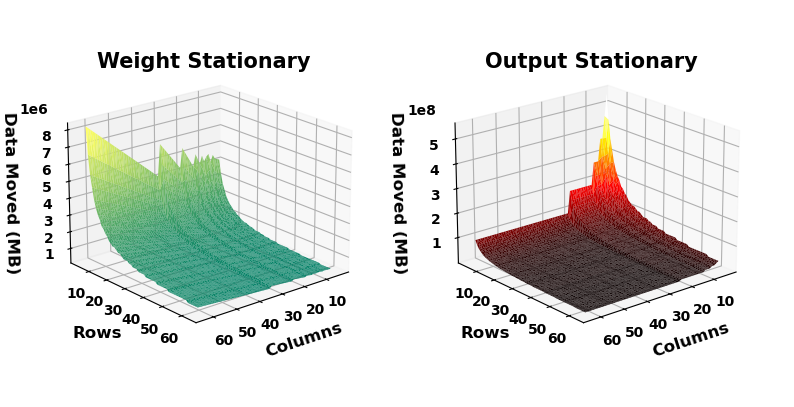

In [7]:
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

ax_ws = fig.add_subplot(121, projection = '3d')
ax_os = fig.add_subplot(122, projection = '3d')

# plotting
ax_ws.plot_trisurf(Xw, Yw, Zw, cmap='summer', linewidth=0)
ax_ws.view_init(20, 50)
ax_ws.set_xlabel('Columns', fontsize=12, labelpad=10)
ax_ws.set_ylabel('Rows', fontsize=12, labelpad=10)
ax_ws.set_zlabel('Data Moved (MB)', fontsize=12, labelpad=10)
ax_ws.set_title('Weight Stationary', weight='bold', fontsize=15, y=0.9)
ax_ws.set_box_aspect(aspect=None, zoom=0.8)
ax_ws.zaxis.get_offset_text().set_visible(False)
ax_ws.text(80, -10, 9*10**6, "1e6")

ax_os.plot_trisurf(Xo, Yo, Zo, cmap='hot', linewidth=0)
ax_os.view_init(20, 50)
ax_os.set_xlabel('Columns', weight='bold', fontsize=12, labelpad=10)
ax_os.set_ylabel('Rows', weight='bold', fontsize=12, labelpad=10)
ax_os.set_zlabel('Data Moved (MB)', weight='bold', fontsize=12, labelpad=10)
ax_os.set_title('Output Stationary', weight='bold', fontsize=15, y=0.9)
ax_os.set_box_aspect(aspect=None, zoom=0.8)
ax_os.zaxis.get_offset_text().set_visible(False)
ax_os.text(80, -10, 6*10**8, "1e8")

fig.subplots_adjust(wspace=0, hspace=0)

# Uncomment below to save plot
#plt.savefig(f"3dMapping.pdf", format='pdf', bbox_inches='tight')

## Min Data Movement Counts

The next loop completes the above loop, but for a range of input data sizes. At the end of each internal loop (changing hardware dimensions), the minimum data moved for that input data is stored.

Runtime ~40mins

In [438]:
kernel_size = 3
image_size = 28
bit_acc = 8

ws_min = []
os_min = []

for kernel in range(16, 256):
    for input_channels in range(1, 256):
        temp_ws = [kernel, input_channels]
        temp_os = [kernel, input_channels]

        check_ws = []
        check_os = []

        for ncol in range(4, 64):
            for nrow in range(4, 64):
                check_ws.append(weight_stationary(bit_acc, nrow, ncol, kernel, kernel_size, kernel_size, image_size, image_size, input_channels)[0])
                check_os.append(output_stationary(bit_acc, nrow, ncol, kernel, kernel_size, kernel_size, image_size, image_size, input_channels)[0])
        
        temp_ws.append(min(check_ws))
        temp_os.append(min(check_os))

        ws_min.append(temp_ws)
        os_min.append(temp_os)

In [474]:
ws_min = np.array(ws_min)
os_min = np.array(os_min)

Xw = ws_min[:, 0]
Yw = ws_min[:, 1]
Zw = ws_min[:, 2]

Xo = os_min[:, 0]
Yo = os_min[:, 1]
Zo = os_min[:, 2]

In [475]:
Zw = Zw/1000
Zo = Zo/1000

C:\Users\ferga\AppData\Local\Temp\ipykernel_19496\3983988898.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('red')
C:\Users\ferga\AppData\Local\Temp\ipykernel_19496\3983988898.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('green')


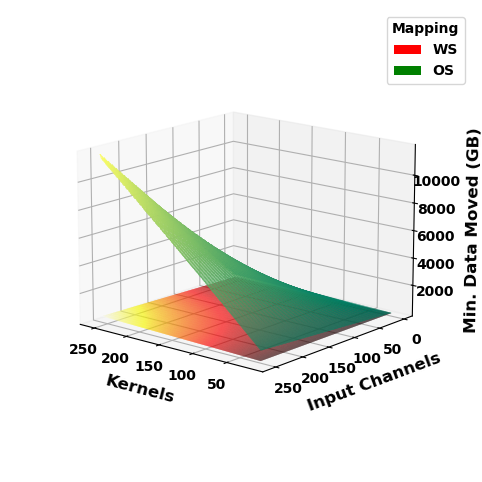

In [470]:
fig = plt.figure(figsize=(8, 6))
fig.tight_layout()

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

ax_ws = fig.add_subplot(111, projection = '3d')

# plotting
ax_ws.plot_trisurf(Xw, Yw, Zw, cmap='summer', linewidth=0, label='WS')
ax_ws.plot_trisurf(Xo, Yo, Zo, cmap='hot', linewidth=0, label='OS')
ax_ws.view_init(15, 130)

ax_ws.set_xlabel('Kernels', fontsize=12, labelpad=10)
ax_ws.set_ylabel('Input Channels', fontsize=12, labelpad=10)
ax_ws.set_zlabel('Min. Data Moved (GB)', fontsize=12, labelpad=10)
ax_ws.set_box_aspect(aspect=None, zoom=0.8)
leg = ax_ws.legend(title='Mapping')
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green')

fig.subplots_adjust(wspace=0, hspace=0)

# Uncomment below to save plot
#plt.savefig(f"minMap3d.pdf", format='pdf', bbox_inches='tight')

## Speed of Inference

The following functions measure how many "sequences" of serial data is required for 3D hardware. This gives an indication of the speed and parallelism each mapping technique exhibits.

The below loop tests the minimum speed of inference for varying hardware dimensions, storing this value, and repeating for increasing data dimensions.

In [486]:
def ws_speed(nrow, ncol, ndepth, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels, padding=0, strides=1, ppq=False):
    
    if ppq:
        nrow = nrow/4
        ncol = ncol/4

    # Shape of Output Convolution
    xOutput = int(((image_x_size - kernel_x_size + 2 * padding) / strides) + 1)
    yOutput = int(((image_y_size - kernel_y_size + 2 * padding) / strides) + 1)

    # Number of weight block partitions to fit into hardware
    block_col = int(np.ceil(kernels/ncol))
    block_row = int(np.ceil(kernel_x_size*kernel_y_size*image_channels/nrow))

    return block_col*block_row*xOutput*yOutput/ndepth

def os_speed(nrow, ncol, ndepth, kernels, kernel_x_size, kernel_y_size, image_x_size, image_y_size, image_channels, padding=0, strides=1, ppq=False):

    if ppq:
        nrow = nrow/4
        ncol = ncol/4

    # Shape of Output Convolution
    xOutput = int(((image_x_size - kernel_x_size + 2 * padding) / strides) + 1)
    yOutput = int(((image_y_size - kernel_y_size + 2 * padding) / strides) + 1)

    
    # Number of weight block partitions to fit into hardware
    block_col = int(np.ceil(xOutput/ncol))
    block_row = int(np.ceil(kernel_x_size*kernel_y_size*image_channels/nrow))
    block_depth = int(np.ceil(yOutput/ndepth))

    return block_col*block_row*block_depth*kernels

Runtime ~10mins

*Note the hardware dimensions do not increase by one at a time to improve runtime massively*.

In [491]:
kernel_size = 3
image_size = 28

ws_sp = []
os_sp = []

for kernel in range(16, 256):
    for input_channels in range(1, 256):
        temp_ws = [kernel, input_channels]
        temp_os = [kernel, input_channels]

        check_ws = []
        check_os = []

        for ncol in range(4, 64, 5):
            for nrow in range(4, 64, 5):
                for ndepth in range(16, 64, 8):
                    check_ws.append(ws_speed(nrow, ncol, ndepth, kernel, kernel_size, kernel_size, image_size, image_size, input_channels))
                    check_os.append(os_speed(nrow, ncol, ndepth, kernel, kernel_size, kernel_size, image_size, image_size, input_channels))
        
        temp_ws.append(min(check_ws))
        temp_os.append(min(check_os))

        ws_sp.append(temp_ws)
        os_sp.append(temp_os)

In [492]:
ws_sp = np.array(ws_sp)
os_sp = np.array(os_sp)

Xw = ws_sp[:, 0]
Yw = ws_sp[:, 1]
Zw = ws_sp[:, 2]

Xo = os_sp[:, 0]
Yo = os_sp[:, 1]
Zo = os_sp[:, 2]

C:\Users\ferga\AppData\Local\Temp\ipykernel_19496\4156475417.py:19: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('red')
C:\Users\ferga\AppData\Local\Temp\ipykernel_19496\4156475417.py:20: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('green')


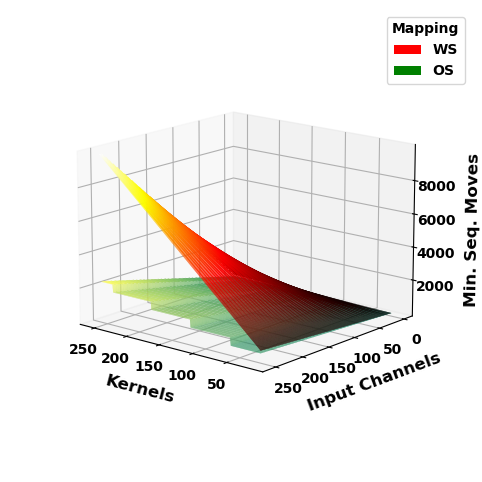

In [494]:
fig = plt.figure(figsize=(8, 6))
fig.tight_layout()

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

ax_ws = fig.add_subplot(111, projection = '3d')

# plotting
ax_ws.plot_trisurf(Xw, Yw, Zw, cmap='summer', linewidth=0, label='WS')
ax_ws.plot_trisurf(Xo, Yo, Zo, cmap='hot', linewidth=0, label='OS')
ax_ws.view_init(15, 130)

ax_ws.set_xlabel('Kernels', fontsize=12, labelpad=10)
ax_ws.set_ylabel('Input Channels', fontsize=12, labelpad=10)
ax_ws.set_zlabel('Min. Seq. Moves', fontsize=12, labelpad=10)
ax_ws.set_box_aspect(aspect=None, zoom=0.8)
leg = ax_ws.legend(title='Mapping')
leg.legendHandles[0].set_color('red')
leg.legendHandles[1].set_color('green')

fig.subplots_adjust(wspace=0, hspace=0)

# Uncomment below to save plot
#plt.savefig(f"minSeq3d.pdf", format='pdf', bbox_inches='tight')